<a href="https://colab.research.google.com/github/harmonicm/AlgoWiki/blob/master/hvae_uc_merced_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load UC Merced dataset
DATASET_PATH = "/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images"
dataset = ImageFolder(root=DATASET_PATH, transform=transform)

# Filter dataset to include any one class and we have selected agricultural here
class_name = "agricultural"
class_idx = dataset.class_to_idx[class_name]
filtered_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
dataset.samples = [dataset.samples[i] for i in filtered_indices]

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

# Check dataset
sample_images, _ = next(iter(dataloader))
print(f"Loaded {len(dataset)} images from '{class_name}' class, sample batch shape: {sample_images.shape}")

Loaded 100 images from 'agricultural' class, sample batch shape: torch.Size([32, 3, 128, 128])


In [ ]:
# Define HVAE model with two hierarchical latent layers
class HVAE(nn.Module):
    def __init__(self, latent_dim1=256, latent_dim2=512):
        super(HVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        self.fc_mu1 = nn.Linear(256 * 16 * 16, latent_dim1)
        self.fc_logvar1 = nn.Linear(256 * 16 * 16, latent_dim1)
        self.fc_mu2 = nn.Linear(latent_dim1, latent_dim2)
        self.fc_logvar2 = nn.Linear(latent_dim1, latent_dim2)

        self.decoder_input = nn.Linear(latent_dim2, 256 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu1, logvar1 = self.fc_mu1(x), self.fc_logvar1(x)
        z1 = self.reparameterize(mu1, logvar1)
        mu2, logvar2 = self.fc_mu2(z1), self.fc_logvar2(z1)
        z2 = self.reparameterize(mu2, logvar2)

        x_recon = self.decoder_input(z2).view(-1, 256, 16, 16)
        x_recon = self.decoder(x_recon)
        return x_recon, mu1, logvar1, mu2, logvar2

In [ ]:
# Define loss function
beta = 0.1  # Weighting factor for KL divergence
def loss_function(x_recon, x, mu1, logvar1, mu2, logvar2):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')  # L2 loss for sharper images, L1 did not yielded good results
    kl_div1 = -0.5 * torch.sum(1 + logvar1 - mu1.pow(2) - logvar1.exp())
    kl_div2 = -0.5 * torch.sum(1 + logvar2 - mu2.pow(2) - logvar2.exp())
    return recon_loss + beta * (kl_div1 + kl_div2)

# Training function
def train(model, dataloader, optimizer, epochs=10):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            x, _ = batch
            x = x.to(device, non_blocking=True)
            optimizer.zero_grad()
            x_recon, mu1, logvar1, mu2, logvar2 = model(x)
            loss = loss_function(x_recon, x, mu1, logvar1, mu2, logvar2)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}, Loss: {avg_loss}")
    return losses

# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Train the model
losses = train(model, dataloader, optimizer, epochs=100)

Epoch 1, Loss: 2574.0007421875
Epoch 2, Loss: 2470.60189453125
Epoch 3, Loss: 2382.9775537109376
Epoch 4, Loss: 2213.88142578125
Epoch 5, Loss: 1938.2870458984376
Epoch 6, Loss: 1421.728623046875
Epoch 7, Loss: 1157.3795703125
Epoch 8, Loss: 1069.1873022460939
Epoch 9, Loss: 1066.87705078125
Epoch 10, Loss: 1096.469990234375
Epoch 11, Loss: 1101.63650390625
Epoch 12, Loss: 1068.5086157226563
Epoch 13, Loss: 1024.5786181640624
Epoch 14, Loss: 1026.9765454101562
Epoch 15, Loss: 1034.9953100585938
Epoch 16, Loss: 1000.7494067382812
Epoch 17, Loss: 973.9551806640625
Epoch 18, Loss: 955.1475610351563
Epoch 19, Loss: 955.7909228515625
Epoch 20, Loss: 949.3718994140625
Epoch 21, Loss: 942.9940087890625
Epoch 22, Loss: 941.721220703125
Epoch 23, Loss: 936.0383251953125
Epoch 24, Loss: 931.016708984375
Epoch 25, Loss: 927.775068359375
Epoch 26, Loss: 922.0009399414063
Epoch 27, Loss: 921.1583642578125
Epoch 28, Loss: 919.2096240234375
Epoch 29, Loss: 915.603330078125
Epoch 30, Loss: 917.8224047

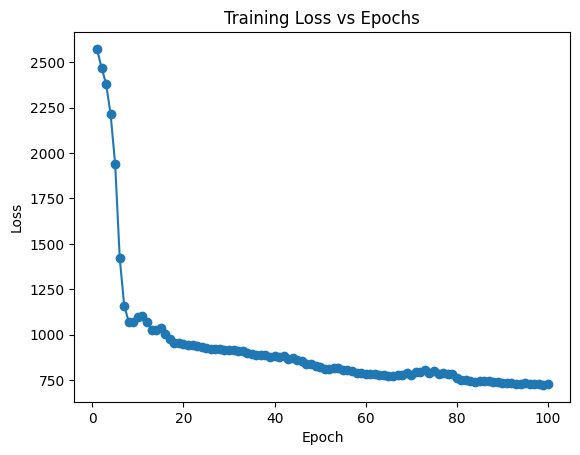

In [ ]:
# Plot loss vs epochs curve curve
plt.plot(range(1, 101), losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.show()

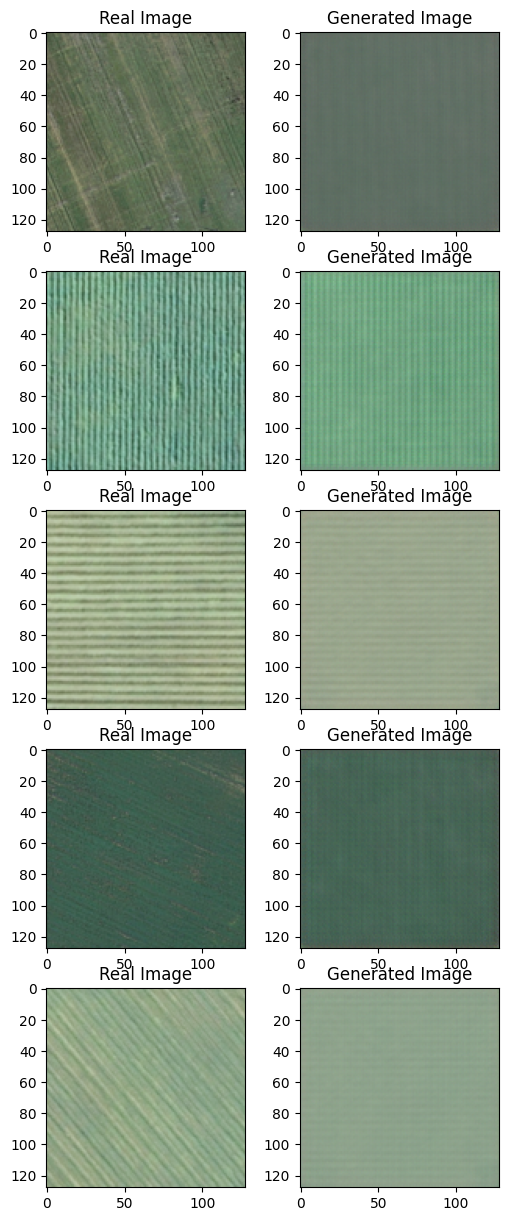

In [ ]:
# Function to show real vs generated images
def show_real_vs_generated(model, dataloader, num_samples=5):
    model.eval()
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_samples].to(device)
    with torch.no_grad():
        mu1, logvar1 = model.fc_mu1(model.encoder(real_images)), model.fc_logvar1(model.encoder(real_images))
        z1 = mu1
        mu2, logvar2 = model.fc_mu2(z1), model.fc_logvar2(z1)
        z2 = mu2
        generated_images = model.decoder(model.decoder_input(z2).view(-1, 256, 16, 16))

    fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples * 3))
    for i in range(num_samples):
        axes[i, 0].imshow(real_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[i, 0].set_title("Real Image")
        axes[i, 1].imshow(generated_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[i, 1].set_title("Generated Image")
    plt.show()

# Show real vs generated images
show_real_vs_generated(model, dataloader)

Here we are different Class that is parking Lot.

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images
    transforms.ToTensor(),         # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load UC Merced dataset
DATASET_PATH = "/kaggle/input/uc-merced-land-use-dataset/UCMerced_LandUse/Images"
dataset = ImageFolder(root=DATASET_PATH, transform=transform)
class_name = "parkinglot"
class_idx = dataset.class_to_idx[class_name]
filtered_indices = [i for i, (_, label) in enumerate(dataset.samples) if label == class_idx]
dataset.samples = [dataset.samples[i] for i in filtered_indices]

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

# Check dataset
sample_images, _ = next(iter(dataloader))
print(f"Loaded {len(dataset)} images from '{class_name}' class, sample batch shape: {sample_images.shape}")

Loaded 100 images from 'parkinglot' class, sample batch shape: torch.Size([32, 3, 128, 128])


In [ ]:
class HVAE(nn.Module):
    def __init__(self, latent_dim1=256, latent_dim2=512):
        super(HVAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten()
        )

        self.fc_mu1 = nn.Linear(256 * 16 * 16, latent_dim1)
        self.fc_logvar1 = nn.Linear(256 * 16 * 16, latent_dim1)
        self.fc_mu2 = nn.Linear(latent_dim1, latent_dim2)
        self.fc_logvar2 = nn.Linear(latent_dim1, latent_dim2)

        self.decoder_input = nn.Linear(latent_dim2, 256 * 16 * 16)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(32, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder(x)
        mu1, logvar1 = self.fc_mu1(x), self.fc_logvar1(x)
        z1 = self.reparameterize(mu1, logvar1)
        mu2, logvar2 = self.fc_mu2(z1), self.fc_logvar2(z1)
        z2 = self.reparameterize(mu2, logvar2)

        x_recon = self.decoder_input(z2).view(-1, 256, 16, 16)
        x_recon = self.decoder(x_recon)
        return x_recon, mu1, logvar1, mu2, logvar2

In [ ]:
import torch
import torch.nn.functional as F

def loss_function(x_recon, x, mu1, logvar1, mu2, logvar2, beta=0.1):
    batch_size = x.size(0)
    recon_loss = F.mse_loss(x_recon, x, reduction='sum') / batch_size  # Normalize
    kl_div1 = -0.5 * torch.sum(1 + logvar1 - mu1.pow(2) - logvar1.exp()) / batch_size
    kl_div2 = -0.5 * torch.sum(1 + logvar2 - mu2.pow(2) - logvar2.exp()) / batch_size
    return recon_loss + beta * (kl_div1 + kl_div2)

def train(model, dataloader, optimizer, epochs=10, beta=0.1, clip_grad=1.0):
    model.train()
    losses = []
    best_loss = float('inf')

    for epoch in range(epochs):
        total_loss = 0
        for batch in dataloader:
            x, _ = batch
            x = x.to(device, non_blocking=True)

            optimizer.zero_grad()
            x_recon, mu1, logvar1, mu2, logvar2 = model(x)
            loss = loss_function(x_recon, x, mu1, logvar1, mu2, logvar2, beta)
            loss.backward()

            if clip_grad:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)

            optimizer.step()
            total_loss += loss.item() * x.size(0)  # Undo batch normalization to get true sum

        avg_loss = total_loss / len(dataloader.dataset)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1:03d}, Loss: {avg_loss:.4f}")

        # Optional: Save model checkpoint if it improves
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), "best_model.pth")

    return losses
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
losses = train(model, dataloader, optimizer, epochs=200, beta=0.1)


Epoch 001, Loss: 8087.9718
Epoch 002, Loss: 7935.8921
Epoch 003, Loss: 7796.9007
Epoch 004, Loss: 7628.9531
Epoch 005, Loss: 7354.1780
Epoch 006, Loss: 7763.2852
Epoch 007, Loss: 7051.2198
Epoch 008, Loss: 6881.0270
Epoch 009, Loss: 6785.6968
Epoch 010, Loss: 6685.7266
Epoch 011, Loss: 6558.4390
Epoch 012, Loss: 6549.1554
Epoch 013, Loss: 6444.6842
Epoch 014, Loss: 6398.2264
Epoch 015, Loss: 6351.8972
Epoch 016, Loss: 6263.1762
Epoch 017, Loss: 6224.4792
Epoch 018, Loss: 6144.0319
Epoch 019, Loss: 6075.3494
Epoch 020, Loss: 6046.6007
Epoch 021, Loss: 5988.2935
Epoch 022, Loss: 5918.7362
Epoch 023, Loss: 5868.5440
Epoch 024, Loss: 5818.6056
Epoch 025, Loss: 5735.6009
Epoch 026, Loss: 5725.3871
Epoch 027, Loss: 5598.1394
Epoch 028, Loss: 5519.4409
Epoch 029, Loss: 5477.6346
Epoch 030, Loss: 5395.4345
Epoch 031, Loss: 5331.9927
Epoch 032, Loss: 5326.3549
Epoch 033, Loss: 5216.2381
Epoch 034, Loss: 5143.8081
Epoch 035, Loss: 5086.3792
Epoch 036, Loss: 5030.2245
Epoch 037, Loss: 5030.3764
E

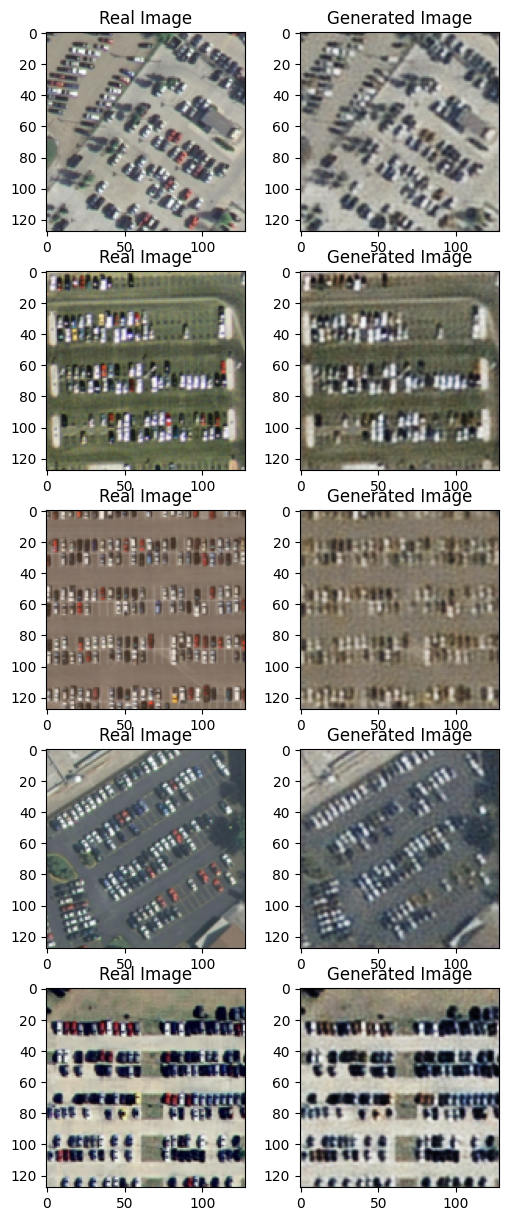

In [ ]:
def show_real_vs_generated(model, dataloader, num_samples=5):
    model.eval()
    real_images, _ = next(iter(dataloader))
    real_images = real_images[:num_samples].to(device)
    with torch.no_grad():
        mu1, logvar1 = model.fc_mu1(model.encoder(real_images)), model.fc_logvar1(model.encoder(real_images))
        z1 = mu1
        mu2, logvar2 = model.fc_mu2(z1), model.fc_logvar2(z1)
        z2 = mu2
        generated_images = model.decoder(model.decoder_input(z2).view(-1, 256, 16, 16))

    fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples * 3))
    for i in range(num_samples):
        axes[i, 0].imshow(real_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[i, 0].set_title("Real Image")
        axes[i, 1].imshow(generated_images[i].cpu().permute(1, 2, 0) * 0.5 + 0.5)
        axes[i, 1].set_title("Generated Image")
    plt.show()
show_real_vs_generated(model, dataloader)

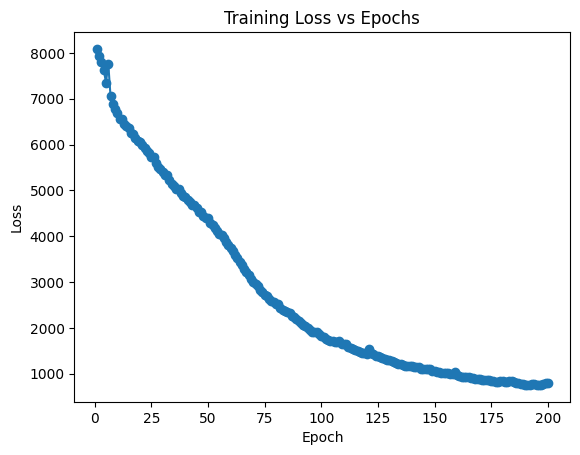

In [ ]:
plt.plot(range(1, 201), losses, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.show()

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def extract_latents(model, dataloader):
    model.eval()
    latents = []
    labels = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            x = x.to(device)
            _, _, _, mu2, _ = model(x)  # Choose mu2 for deep latent space
            latents.append(mu2.cpu())
            labels.append(y)
    latents = torch.cat(latents).numpy()
    labels = torch.cat(labels).numpy()
    return latents, labels


In [ ]:
def plot_tsne(latents, labels, perplexity=30, n_iter=1000):
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
    latents_2d = tsne.fit_transform(latents)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='tab10', s=5)
    plt.colorbar(scatter, label="Class Label")
    plt.title("t-SNE of Latent Space (mu2)")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.show()


Running t-SNE...


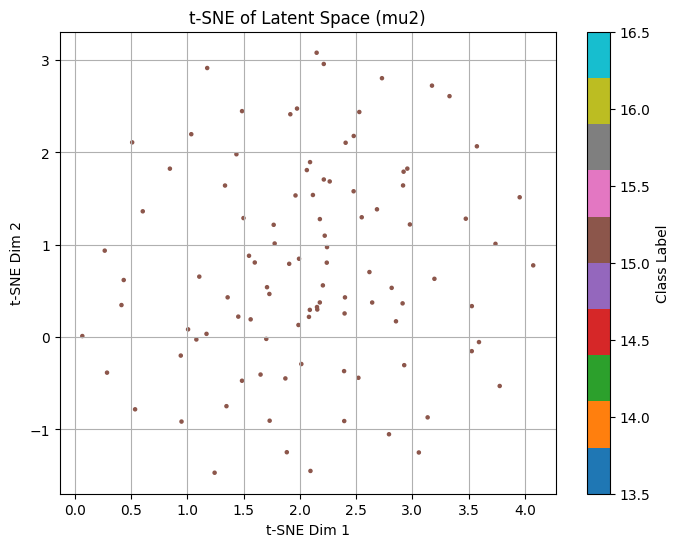

In [ ]:
latents, labels = extract_latents(model, dataloader)
plot_tsne(latents, labels)
